Initializiation

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
%matplotlib inline
import sys
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]


# An exploration in solving the Navier-Stokes equations in Two Dimensions

## Introduction
The Navier-Stokes equations are a set of equations that describe the motion of viscous fluid substances. These
equations were discovered by Claude-Louis Navier and George Gabriel Stokes by applying Newton’s second law to
fluid motion. This, along with the assumption that stress in the fluid is the sum of a diffusing viscous term and a
pressure term, led to the the set of coupled differential equations that describe how the velocity, pressure, temperature, and density of a moving fluid are related. I will seek to solve these differential equations in two dimensions, and explore a few different flow configurations.

The Navier-Stokes equations are a set of coupled differential equations, and could in theory be solved analytically
for a given flow problem. In practice, however, these equations are much too difficult to solve analytically. From the
textbook: ”[The] equations are complicated and nonlinear, there are many degrees of freedom, the non linearities may lead to instabilities, analytic solutions are rare, and the boundary conditions for realistic geometries (like airplanes) are not intuitive.” Previously, engineers were able to make approximations and simplifications to the equation set until they were solvable, but recently, computers have been used to solve the full equations in an area of study known ascomputational fluid dynamics (CFD). First, the Navier-Stokes equations must be discretized using one of the many discretization methods, such as the finite difference method, the finite volume method, or finite element method. Most of the top level CFD programs use the finite volume method, but I will be using the finite difference method as that is the most familiar to me and the method on which I was able to find the most resources.

## The Equations
As noted in the introduction, the Navier-Stokes equations are incredibly complex, so in this notebook we make some simplifications. First, we will be working in two dimensions, which eliminate any z-components. Second, we assume the fluid is incompressible, implying a constant density $\rho = 1$. The continuity equation $$\frac{D_{\rho}}{D_t} + \rho(\nabla \cdot \vec{v}) = 0$$ then becomes $$\frac{\partial u_{x}}{\partial x} + \frac{\partial u_{y}}{\partial y} = 0$$ where u is the velocity in the x-direction and v is the velocity in the y-direction.

The momentum equation in vector form can be expressed as $$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v}=-\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}$$ After some complex calculus and algebra done by the authors of the textbook, the momentum equation becomes a system of differential equations: one equation for each of the velocity components u and v, and another equation for the pressure: 
$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) $$
$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) $$
$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$ 
These terms must now be discretized in order to work in our algorithm, much like we did in class.

### Discretization
I will not write out each step explicitly, but after some patience and some painstaking algebra, the discretized equations can be written as follows (note: the timestep is discretized as a forward difference while the spatial terms are will be discretized as backward differences):
* the u-momentum equation 
$$
\frac{u_{i,j}^{n+1}-u_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{u_{i,j}^{n}-u_{i,j-1}^{n}}{\Delta y} = \\ 
\qquad -\frac{1}{\rho}\frac{p_{i+1,j}^{n}-p_{i-1,j}^{n}}{2\Delta x}+\nu\left(\frac{u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}}{\Delta x^2}+\frac{u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}}{\Delta y^2}\right)
$$
* the v-momentum equation
$$
\frac{v_{i,j}^{n+1}-v_{i,j}^{n}}{\Delta t}+u_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i-1,j}^{n}}{\Delta x}+v_{i,j}^{n}\frac{v_{i,j}^{n}-v_{i,j-1}^{n}}{\Delta y} = \\
\qquad -\frac{1}{\rho}\frac{p_{i,j+1}^{n}-p_{i,j-1}^{n}}{2\Delta y}
+\nu\left(\frac{v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}}{\Delta x^2}+\frac{v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}}{\Delta y^2}\right)
$$
* and the pressure equation
$$
\begin{split}
& \frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2} = \\
& \qquad \rho \left[ \frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right) -\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} - 2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x} - \frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$
In these equations, the n-index represents the time step, and we must rearrange these equations in the way the time step iterations will advance in the code. That is, we need to isolate the n+1 term on the left side of the equation, such that the next time step depends on the previous step.

* the rearranged u-momentum equation
$$
\begin{split}
u_{i,j}^{n+1} = u_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(u_{i,j}^{n}-u_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(u_{i,j}^{n}-u_{i,j-1}^{n}\right) \\
& - \frac{\Delta t}{\rho 2\Delta x} \left(p_{i+1,j}^{n}-p_{i-1,j}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\right)\right)
\end{split}
$$
* the rearranged v-momentum equation
$$
\begin{split}
v_{i,j}^{n+1} = v_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(v_{i,j}^{n}-v_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(v_{i,j}^{n}-v_{i,j-1}^{n})\right) \\
& - \frac{\Delta t}{\rho 2\Delta y} \left(p_{i,j+1}^{n}-p_{i,j-1}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}\right)\right)
\end{split}
$$
* the rearranged pressure equation
$$
\begin{split}
p_{i,j}^{n} = & \frac{\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}\right) \Delta y^2 + \left(p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) \Delta x^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& -\frac{\rho\Delta x^2\Delta y^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& \times \left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

## Forced Flow Through a Pipe
Now that we have our discretized differential equations, we can begin to examine a few situations. The first we will examine is an extremely simple case: forced flow through a pipe. To accomplish this, we can simply add a force term to the u-momentum equation:
$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu\left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right)+F$$
Discretized and rearranged, this equation looks like:
$$
\begin{split}
u_{i,j}^{n+1} = u_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(u_{i,j}^{n}-u_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(u_{i,j}^{n}-u_{i,j-1}^{n}\right) \\
& - \frac{\Delta t}{\rho 2\Delta x} \left(p_{i+1,j}^{n}-p_{i-1,j}^{n}\right) \\
& + \nu\left[\frac{\Delta t}{\Delta x^2} \left(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\right)\right] \\
& + \Delta t F
\end{split}
$$
Assuming we are examining a small portion of a much longer pipe, we cannot artifically cut off the flow at the ends of the pipe. Therefore, we must make the u-momentum and pressure equations periodic in x to simulate a small portion of a longer pipe.
### Functions

In [76]:
# this function solves the pressure differential equation for periodic boundary conditions. The boundary conditions
# are periodic because we are not artificially cutting off the flow at the ends of the pipe. This cross section of 
# the pipe is assumed to be a small portion of a much longer pipe.
def pressurePeriodic(p, b, u, v, dx, dy):
    #calculates term inside brackets of pressure differential equation
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) -
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    pn = np.empty_like(p)
    
    # this for loop is set up to segregate the different rounds of claculations, hence the pseudotime nit.
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        
        # these boundary conditions ensure that the pressure is the same at the inlet and outlet, as we 
        # are not cutting off the flow, but rather examining this cross section as a piece of a longer pipe.
        # periodic BC ressure @ x = 2
        p[1:-1, -1] = (((pn[1:-1, 0] + pn[1:-1, -2])* dy**2 +
                        (pn[2:, -1] + pn[0:-2, -1]) * dx**2) /
                       (2 * (dx**2 + dy**2)) -
                       dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, -1])

        # eriodic BC ressure @ x = 0
        p[1:-1, 0] = (((pn[1:-1, 1] + pn[1:-1, -1])* dy**2 +
                       (pn[2:, 0] + pn[0:-2, 0]) * dx**2) /
                      (2 * (dx**2 + dy**2)) -
                      dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1, 0])
        
        # wall boundary conditions
        p[-1, :] = p[-2, :]  # dp/dy = 0 at y = 2
        p[0, :]  = p[1, :]   # dp/dy = 0 at y = 0
        
    return p


def forcedFlow(p, b, u, v, dx, dy, udiff, stepcount):
    # this loop runs while the difference between iterations of the differential equation is higher than some
    # defined tolerance
    while udiff > tol:
        # copies x-velocity and y-velocity arrays
        un = u.copy()
        vn = v.copy()
        
        # solves the pressure differential equation for every iteration of the loop
        p = pressurePeriodic(p, b, u, v, dx, dy)

        # solves the x-velocity diff eq for each iteration
        u[1:-1, 1:-1] = (un[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx * 
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy * 
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * 
                        (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 * 
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])) + 
                         F * dt)

        # solves the y-velocity diff eq for each iteration
        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx * 
                        (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy * 
                        (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                         dt / (2 * rho * dy) * 
                        (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                         nu * (dt / dx**2 *
                        (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                         dt / dy**2 * 
                        (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # periodic BC for u at x = 2     
        u[1:-1, -1] = (un[1:-1, -1] - un[1:-1, -1] * dt / dx * 
                      (un[1:-1, -1] - un[1:-1, -2]) -
                       vn[1:-1, -1] * dt / dy * 
                      (un[1:-1, -1] - un[0:-2, -1]) -
                       dt / (2 * rho * dx) *
                      (p[1:-1, 0] - p[1:-1, -2]) + 
                       nu * (dt / dx**2 * 
                      (un[1:-1, 0] - 2 * un[1:-1,-1] + un[1:-1, -2]) +
                       dt / dy**2 * 
                      (un[2:, -1] - 2 * un[1:-1, -1] + un[0:-2, -1])) + F * dt)

        # periodic BC for u at x = 0
        u[1:-1, 0] = (un[1:-1, 0] - un[1:-1, 0] * dt / dx *
                     (un[1:-1, 0] - un[1:-1, -1]) -
                      vn[1:-1, 0] * dt / dy * 
                     (un[1:-1, 0] - un[0:-2, 0]) - 
                      dt / (2 * rho * dx) * 
                     (p[1:-1, 1] - p[1:-1, -1]) + 
                      nu * (dt / dx**2 * 
                     (un[1:-1, 1] - 2 * un[1:-1, 0] + un[1:-1, -1]) +
                      dt / dy**2 *
                     (un[2:, 0] - 2 * un[1:-1, 0] + un[0:-2, 0])) + F * dt)

        # periodic BC for v at x = 2
        v[1:-1, -1] = (vn[1:-1, -1] - un[1:-1, -1] * dt / dx *
                      (vn[1:-1, -1] - vn[1:-1, -2]) - 
                       vn[1:-1, -1] * dt / dy *
                      (vn[1:-1, -1] - vn[0:-2, -1]) -
                       dt / (2 * rho * dy) * 
                      (p[2:, -1] - p[0:-2, -1]) +
                       nu * (dt / dx**2 *
                      (vn[1:-1, 0] - 2 * vn[1:-1, -1] + vn[1:-1, -2]) +
                       dt / dy**2 *
                      (vn[2:, -1] - 2 * vn[1:-1, -1] + vn[0:-2, -1])))

        # periodic BC for v at x = 0
        v[1:-1, 0] = (vn[1:-1, 0] - un[1:-1, 0] * dt / dx *
                     (vn[1:-1, 0] - vn[1:-1, -1]) -
                      vn[1:-1, 0] * dt / dy *
                     (vn[1:-1, 0] - vn[0:-2, 0]) -
                      dt / (2 * rho * dy) * 
                     (p[2:, 0] - p[0:-2, 0]) +
                      nu * (dt / dx**2 * 
                     (vn[1:-1, 1] - 2 * vn[1:-1, 0] + vn[1:-1, -1]) +
                      dt / dy**2 * 
                     (vn[2:, 0] - 2 * vn[1:-1, 0] + vn[0:-2, 0])))


        # no-slip boundary conditions along top and bottom surfaces:
        # u,v = 0 @ y = 0,2
        u[0, :] = 0
        u[-1, :] = 0
        v[0, :] = 0
        v[-1, :]=0

        # calculates the difference between each iteration to be compared against the defined tolerance.
        udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
        stepcount += 1

    return u, v, p, stepcount


### Parameters
Here, we define the parameters that we will use in this simulation.

In [83]:
nx = 101
ny = 41

xspan = 10.
yspan = 2.
nit = 50
c = 1
tol = 0.001
qScale = 2
udiff = 1
stepcount = 0
    
dx = xspan / (nx - 1)
dy = yspan / (ny - 1)
x = np.linspace(0, xspan, nx)
y = np.linspace(0, yspan, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001
F = 1.




### Plot

In  860  iterations, a tolerance of  0.001  was met.


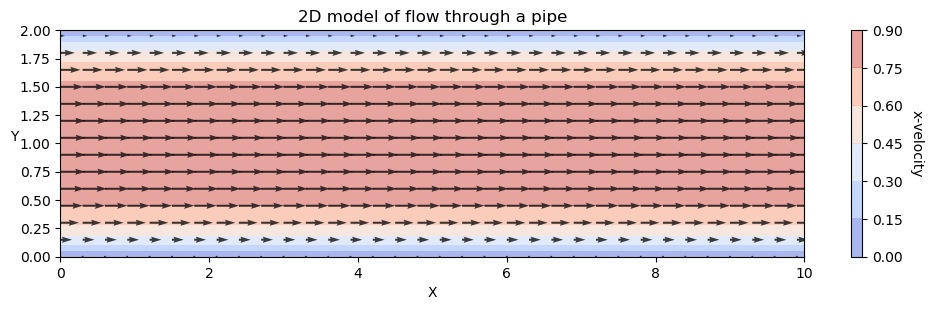

In [81]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

#solves the Navier-Stokes equations for forced flow through a pipe
u, v, p, count = forcedFlow(p, b, u, v, dx, dy, udiff, stepcount)

#contour plot of velocity as a function of X and Y
print('In ', count, ' iterations, a tolerance of ', tol, ' was met.')
figure = plt.figure(figsize=(12, 3), dpi=100)
plt.contourf(X, Y, u, cmap = cm.coolwarm, alpha = 0.5)
cbar = plt.colorbar()
cbar.set_label('x-velocity', rotation=270, labelpad = 15)
plt.quiver(X[::qScale, ::qScale], Y[::qScale, ::qScale], u[::qScale, ::qScale], 
           v[::qScale, ::qScale], alpha = 0.75)
plt.xlabel('X')
plt.ylabel('Y', rotation = 0)
plt.title('2D model of flow through a pipe')
plt.show()




# Flow in a Cavity
The second situation we will examine is the flow inside a cavity with fluid flowing along the top surface (imagine a hole on the bottom of a river). Here, we set the u-momentum = 1 and the pressure = 0 along the upper surface to simulate water flowing freely across the top of the cavity, and we apply the no-slip boundary condition to the sides and bottom of the cavity (velocity = 0 along surfaces). The pressure cannot change along the surfaces, so $\frac{\partial P}{\partial x} = 0$ at the sides and $\frac{\partial P}{\partial y} = 0$ along the bottom.
### Functions

In [66]:
# this function calculates the discretized pressure PDE
def cavityPressure(p, b, u, v, dx, dy):
    # b is the term inside the brackets, just to make calculating without messing up indices easier
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) -
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
    
    pn = np.empty_like(p)
    
    # this for loop is set up to segregate the different rounds of claculations, hence the pseudotime nit.
    for q in range(nit):
        # create a copy of the p array to advance in time
        pn = p.copy()
        # set new values of the pressure array as a function of the old values
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        # boundary conditions on p
        p[:, -1] = p[:, -2] # dp/dx = 0 at right wall
        p[0, :] = p[1, :]   # dp/dy = 0 at bottom surface
        p[:, 0] = p[:, 1]   # dp/dx = 0 at left wall
        p[-1, :] = 0        # p = 0 at top surface
        
    return p

# this function encapsulates the finite difference method of calculating the explicit values of the x and y 
# velocity components of the Navier-Stokes equation
def cavityFlow(p, b, u, v, dx, dy, udiff, stepcount):
    while udiff > tol:
        # copies u and v to advance in time 
        un = u.copy()
        vn = v.copy()
        # calulates the solution to the pressure differential equation for every step in time
        p = cavityPressure(p, b, u, v, dx, dy)

        # discretized x-velocity differenital equation
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
        
        # discretized y-velocity differential equation
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # no-slip boundary conditions on all the walls
        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        # set velocity along cavity lid equal to 1
        u[-1, :] = 1    
        
        # calculates the difference between each iteration to be compared against the defined tolerance.
        udiff = (np.sum(u) - np.sum(un)) / np.sum(u)
        stepcount += 1

    return u, v, p, stepcount

### Parameters

In [85]:
nx = 41
ny = 41

xspan = 2.
yspan = 2.
nit = 50
nt = 500
c = 1
# Converges very quickly, so can set a high tolerance to improve graphic quality.
tol = 0.00000000000001

dx = xspan / (nx - 1)
dy = yspan / (ny - 1)
x = np.linspace(0, xspan, nx)
y = np.linspace(0, yspan, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001
qScale = 2


### Plot

In  87  iterations, a tolerance of 1e-14  was reached.


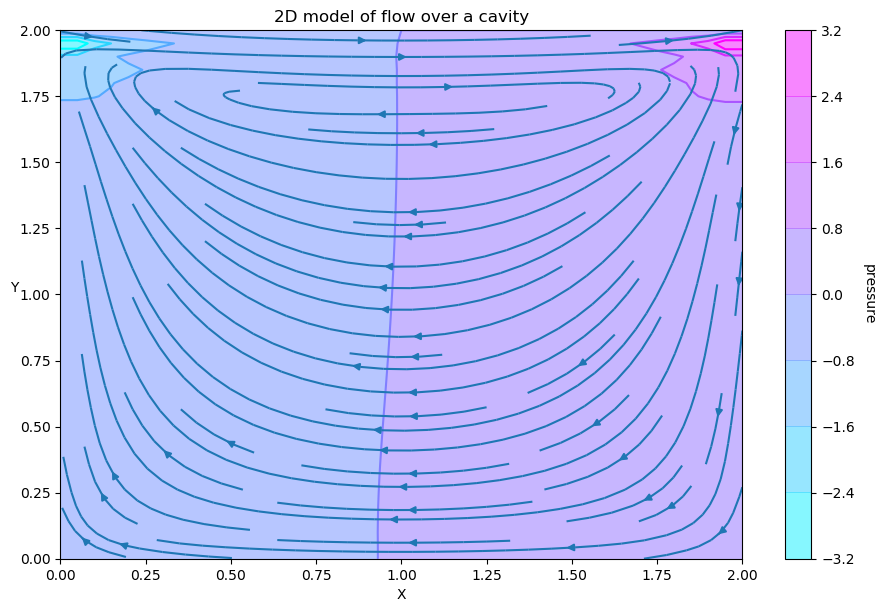

In [86]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

udiff = 1
stepcount = 0
# solves the Navier-Stokes equtions for flow over a cavity
u, v, p, count = cavityFlow(p, b, u, v, dx, dy, udiff, stepcount)

print('In ', count, ' iterations, a tolerance of', tol, ' was reached.')
figure = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, cmap = cm.cool, alpha = 0.5)
cbar = plt.colorbar()
cbar.set_label('pressure', rotation=270, labelpad = 15)
plt.contour(X, Y, p, cmap = cm.cool)
#plt.quiver(X[::qScale, ::qScale], Y[::qScale, ::qScale], u[::qScale, ::qScale], v[::qScale, ::qScale],0)
plt.streamplot(X, Y, u, v)
#plt.grid()
plt.xlabel('X')
plt.ylabel('Y', rotation = 0)
plt.title('2D model of flow over a cavity')
plt.show()

Note the two distinct pressure regions forming on the left and right sides of the cavity and the circular nature of the velocity field. 

# Flow Around an Obstacle
We can now use concepts from the forced flow through a pipe and the cavity flow to model the flow around an obstacle. the main difference between the algorithm used in the above simulations and in simulating a flow around an obstacle is properly setting the boundary conditions. This was by far the hardest part for me to nail down, and after some help from Professor Deustch, we settled on Neumann boundary conditions for both the obstacle and the top, bottom, and side surfaces. 

### Neumann Boundary Conditions
We can rearrange the momentum equation $\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v}=-\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}$ and solve for p:
$$\nabla p= \rho( -\frac{\partial \vec{v}}{\partial t}-\vec{v}\cdot\nabla\vec{u}+\nu\nabla^2\vec{v})$$
Then, multiplying both sides by a normal vector $\vec{n}$, we get
$$\vec{n} \cdot \nabla p= \rho\vec{n} \cdot ( -\frac{\partial \vec{v}}{\partial t}-\vec{v}\cdot\nabla\vec{u}+\nu\nabla^2\vec{v})$$
Along rigid boundaries, the velocity simplifies to zero due to the no-slip condition, and we get
$$\frac{\partial \rho}{\partial x} = \rho\nu\frac{\partial^2 u}{\partial x^2}$$
along x = 0 and x = 2 and
$$\frac{\partial \rho}{\partial y} = \rho\nu\frac{\partial^2 v}{\partial y^2}$$
along y = 0 and y = 2. Now we approximate the second derivative with
$$\frac{\partial^2 u}{\partial x^2} = \frac{1}{\Delta x^2}(u_{i,j}-2 u_{i,j+1}+u_{i,j+2})$$
Therefore, the above boundary condtions are:
$$p_{i,j} = p_{i,j+1} - \frac{\rho\nu}{\Delta x}(-2 u_{i,j+1}+u_{i,j+2})$$

$$p_{i,j} = p_{i+1,j} - \frac{\rho\nu}{\Delta x}(-2 v_{i+1,j}+v_{i+2,j})$$

### Functions

In [123]:
def obstaclePressure(p, u, v, dx, dy, rho, base, height, left, width):
    pn = np.empty_like(p)
    p = np.zeros((ny, nx))
  
    # calculates term inside brackets of pressure differential equation
    b[1:-1,1:-1] = rho * (1 / dt * ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dx) + (v[2:,1:-1] - v[0:-2,1:-1]) / 
                        (2 * dy)) - ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dx))**2 - 2 * ((u[2:,1:-1] - u[0:-2,1:-1]) /
                        (2 * dy) * (v[1:-1,2:] - v[1:-1,0:-2]) / (2 * dx)) - ((v[2:,1:-1] - v[0:-2,1:-1]) / 
                        (2 * dy))**2)

    # this for loop is set up to segregate the different rounds of claculations, using the pseudotime nit.
    for q in range(nit):
        pn = p.copy()
        p[1:-1,1:-1] = ((pn[1:-1,2:] + pn[1:-1,0:-2]) * dy**2 + (pn[2:,1:-1] + pn[0:-2,1:-1]) * dx**2) / (2 * 
                        (dx**2 + dy**2)) - dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * b[1:-1,1:-1]

       
        # here, we apply the Neumann boundary condition on all surfaces
        # at y = 0
        p[0,:] = p[1,:] - rho * nu / dy * (-2 * v[1,:] + v[2,:])
        # at y = 2
        p[-1,:] = p[-2,:] - rho * nu / dy * (-2 * v[-2,:] + v[-3,:])
       
        # at x = 0
        p[:,0] = p[:,1] - rho * nu / dx * (-2 * u[:,1] + u[:,2])
        # at x = 2
        p[:,-1] = p[:,-2] - rho * nu / dx * (-2 * u[:,-2] + u[:,-3])  
        
        # now, we apply the same Neumann boundary conditions at the top and bottom surfaces of the obstacles.     
        # top surface (x = left : left + width, y = base + height):
        p[(base+height),left:(left+width+1)] = p[(base+height+1),left:(left+width+1)] - rho * nu / dy * (-2 * 
                                                v[(base+height+1),left:(left+width+1)] + v[(base+height+2),
                                                left:(left+width+1)])
        
        # bottom surface (x = left + width, y = base):      
        p[base,left:(left+width+1)] = p[base-1,left:(left+width+1)] - rho * nu /dy * (-2 * 
                                        v[base-1,left:(left+width+1)] + v[base-2,left:(left+width+1)])

        # for the right and left surfaces of the obstacles
        # left surface (x = left, y = base : base + height):
        p[base:(base+height+1),left] = p[base:(base+height+1),left-1] - rho * nu / dx * (-2 * 
                                        u[base:(base+height+1),left-1] + u[base:(base+height+1),left-2])
        
        # right surface (x = left + width, y = base : base + height):
        p[base:(base+height+1),(left+width)] = p[base:(base+height+1),(left+width+1)] - rho * nu / dx * (-2 * 
                                                u[base:(base+height+1),(left+width+1)] + u[base:(base+height+1),
                                                (left+width+2)])
        
        # Pressure values inside obstacle should be zero
        # since there is no pressure flux in and out of the obstacle
        p[(base+1):(base+height),(left+1):(left+width)] = 0
        
    return p

def obstacleFlow(nt, u, v, dt, dx, dy, p, rho, nu, base, height, left, width, u_start):#, udiff, stepcount):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))
    
    # initialize all values of u along left edge (x = 0) to some starting value
    u[:,0] = u_start

    # iterate through timesteps
    # could not get convergence algorithm working for this simulation in time
    for n in range(nt):
        # copy arrays to advance in time
        un = u.copy()
        vn = v.copy()
        
        # solves pressure differential equation in each iteration of the loop
        # by implementing the boundary conditions in the pressure function, the boundary conditions will be held 
        # for each iteration.
        p = obstaclePressure(p, u, v, dx, dy, rho, base, height, left, width)

        # solves the u-momentum differential equation for every iteration
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        # solves the y-momentum differential equation for every iteration
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        # here, we apply boundary conditions on the u- and v-momentum equations for each of the surfaces in the 
        # simulation

        # boundary condition at the inlet (x = 0):
        # more fluid flows in through the inlet at each time step
        u[:,0] = u_start

        # at the exit, we set an artificial boundary condition because we are artificially cutting off the flow. 
        # After much deliberation with Prof. Deutsch, we decide to set zero gradient in the x-direction 
        u[:,-1] = u[:,-2]
        
        # here we apply the no slip boundary condition mentioned in the previous simulations for the top and 
        # bottom surfaces
        u[0,:] = 0
        u[-1,:] = 0
        
        # here we set the vertical components of the velocity to be zero at the inlet and exit to force laminar flow
        v[:,-1] = 0 
        v[:,0]  = 0 
        
        # set the vertical component of velocity to be zero at top and bottom surfaces
        v[0,:]  = 0
        v[-1,:] = 0
        
        # now, we must apply boundary conditions at the surface of the obstace for the velocity components. 
        # this is much less involved thatn the Neumann boundary conditions we set for the pressure

        # set velocity equation to zero everywhere within the obstacle
        u[base:(base+height+1),left:(left+width+1)] = 0
        v[base:(base+height+1),left:(left+width+1)] = 0

    return u, v, p


### Parameters

In [124]:
nx = 201  
ny = 101  
nit = 50
c = 1                       
x_span = 20.0
y_span = 10.0
dx = x_span / (nx - 1)           
dy = y_span / (ny - 1)           
x = np.linspace(0, x_span, nx) 
y = np.linspace(0, y_span, ny) 
X, Y = np.meshgrid(x,y)       

# location of base of obstacle in grid
base  = 30
# height of obstacle
height  = 40           

# left boundary of obstacle in grid
left   = 70
# width of obstacle
width   = 10

nt = 100  
# initial velocity of fluid entering at the inlet
u_start = 1
rho = 1               
nu = 0.04
dt = 0.001

qres = 3



### Plot

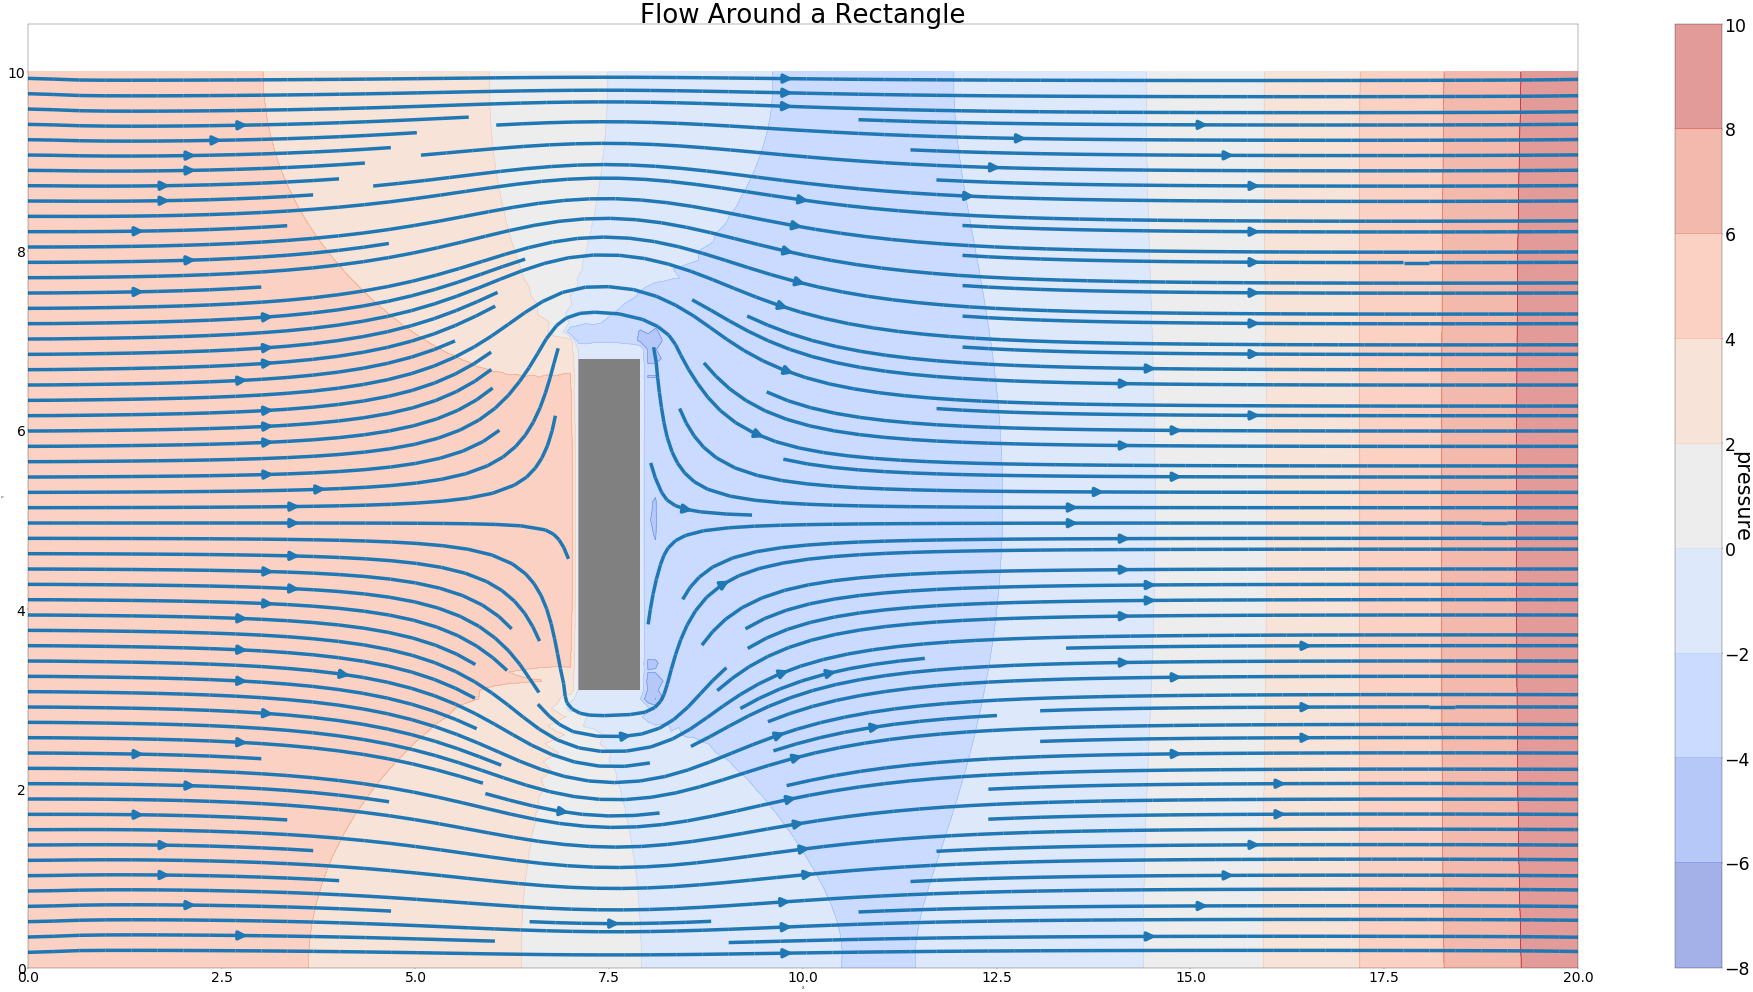

In [129]:
# initialize u = 1 everywhere to improve stability
u = np.ones((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

# solves the Navier-Stokes equtions for flow over a cavity
u, v, p = obstacleFlow(nt, u, v, dt, dx, dy, p, rho, nu, base, height, left, width, u_start)

fig = plt.figure(figsize = (100,50), dpi = 25)
plt.title('Flow Around a Rectangle', fontsize = 75)
plt.contourf(X, Y, p, alpha = 0.5, cmap = cm.coolwarm)
plt.tick_params(axis='both', which='major', labelsize=40)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=50)
cbar.set_label('pressure', rotation = 270, fontsize = 60)
plt.contour(X, Y, p, cmap = cm.coolwarm)
#plt.quiver(X[::qres,::qres],Y[::qres,::qres],u[::qres,::qres],v[::qres,::qres]) ##plotting velocity
plt.streamplot(X, Y, u, v, density = 2, linewidth = 10, arrowsize = 5)
plt.broken_barh([(x[left+1],x[left+width-1]-x[left+1])], (y[base+1],y[base+height-2]-y[base+1]), 
                hold=None, facecolors='grey',)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Moving Forward
Moving forward, I would like to be able to use parts of this algorithm to model more complex surfaces. The discretizaion turned out to be relatively easy (just painstaking and a bit tedious), and the most difficult part was coming up with the appropriate boundary conditions for each situation. I think coming up with boundary conditions for obstacles more complicated than a rectangle would prove to be somewhat difficuly, especially having never taken a course in fluid mechanics. 

These difficulties in boundary conditions can be somewhat alleviated by switching around the algorithm a bit. In the textbook, the authors choose to model the flow around a rectangular obstacle using the stream function and vorticity, which eliminates the third differential equation required for the pressure and reduces the problem to one differential equation each for the stream function and the vorticity. This method simplifies the calculations and algorithm a bit but requires much more care in setting the boundary conditions. 

As mentioned in the introduction, the most cutting edge computational fluid dynamics programs use the finite volume method for calculations that improves upon the finite difference method used in this notebook by imposing volume conservation. This results in very accurate solutions, but at the cost of making the code much more difficult and significantly increasing the processing power needed. The boundary element method discretizes the points along the boundary of the obstacle, making it useful in simulations where large domains are required, and making it relatively simple to code and debug. 

By learning and mastering the implementation of the above techniques, I believe I can build upon the algorithm in thise notebook and be able to write new code for new situations. 

# References
(1) https://www.grc.nasa.gov/www/k-12/airplane/nseqs.html

(2) Landau, Rubin H., $\textit{Computational Physics: Problem Solving with Python}$

(3) Acheson, D. J. (1990), Elementary Fluid Dynamics

(4) http://farside.ph.utexas.edu/teaching/336L/Fluidhtml/

(5) https://confluence.cornell.edu/display/SIMULATION/Big+Ideas%3A+Fluid+Dynamics